# Transformer from Scratch

In [1]:
# Libraries

import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization, Conv1D, Reshape

print(tf.__version__) # 2.9.0 works 

2.9.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


## Attention

### Single Head Attention Layer 

Recall the Attention Layer 
$$ \text{Softmax}\left (\frac{Q \times K^{T}}{\sqrt{d_k}} \right )V = Z $$
Where Q is the Query matrix, K is the Key matrix and V is the value matrix.

In [3]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Calculate the attention weights.

    Arguments:
        Q -- query shape == (..., Tq, dk)
        K -- key shape == (..., Tv, dk)
        V -- value shape == (..., Tv, dv)
        mask: Float tensor with shape broadcastable to (..., Tq, Tv). Defaults to None.

    Returns:
        output -- (attention,attention_weights)
    """
    
    #Compute the scaled dot-product Q•K
    matmul_QK = tf.matmul(Q,K,transpose_b=True)  # dot-product of shape (..., Tq, Tv)

    dk = K.shape[-1]
    scaled_attention_logits = matmul_QK/np.sqrt(dk) # scaled dot-product of shape (..., Tq, Tv)

    # Add the mask to the scaled dot-product
    if mask is not None: 
        scaled_attention_logits += (1. - mask) *(-1e9)

    # Compute the Softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # weights of shape (..., Tq, Tv)

    #Multiply with V
    output = tf.matmul(attention_weights,V)  # Attention representation of shape (..., Tq, dv)
    
    return output, attention_weights

In [24]:
## DEBUG

batch_size = 16
Tq = 39
Tv = 9
dk = 64
dv = 128 

Q= tf.random.uniform((batch_size,Tq, dk))
K= tf.random.uniform((batch_size,Tv, dk))
V= tf.random.uniform((batch_size,Tv, dv))

A,_=scaled_dot_product_attention(Q, K, V)
print(A.shape)

(16, 39, 128)


### Multi Head Attention

In [25]:
class Multihead_Attention(tf.keras.layers.Layer):
    def __init__(self, H, d_model, dk, dv):
        
        """
        Arguments:
        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        """
    
        super(Multihead_Attention, self).__init__()
        
        initializer = tf.keras.initializers.GlorotUniform()
        self.WQ = tf.Variable(initializer(shape=(H, d_model, dk)), trainable=True)
        self.WK = tf.Variable(initializer(shape=(H, d_model, dk)), trainable=True)
        self.WV = tf.Variable(initializer(shape=(H, d_model, dv)), trainable=True)
        self.WO = tf.Variable(initializer(shape=(H*dv,d_model)), trainable=True)

    
    def call(self, Q, K, V, mask=None):
        """
        Calculate the attention weights.

        Arguments:
            Q -- query shape == (..., Tq, d_model)
            K -- key shape == (..., Tv, d_model)
            V -- value shape == (..., Tv, d_model)
            mask: Float tensor with shape broadcastable to (..., Tq, Tv). Defaults to None.

        Returns:
            output -- Multihead attention A of shape (batch_size, Tq, d_model)
        """
        #Projecting Q,K,V to Qh, Kh, Vh. The H projection are stacked on the penultiem axis
        Qh= tf.experimental.numpy.dot(Q, self.WQ) #of shape (batch_size, Tq, H, dk)
        Kh= tf.experimental.numpy.dot(K, self.WK) #of shape (batch_size, Tv, H, dk)
        Vh= tf.experimental.numpy.dot(V, self.WV) #of shape (batch_size, Tv, H, dv)
        
        #Transposition
        Qh=tf.transpose(Qh, [0,2,1,3]) #of shape (batch_size, H, Tq, dk)
        Kh=tf.transpose(Kh, [0,2,1,3]) #of shape (batch_size, H, Tv, dk)
        Vh=tf.transpose(Vh, [0,2,1,3]) #of shape (batch_size, H, Tv, dv)
        
        # Computing the dot-product attention
        Ah,_=scaled_dot_product_attention(Qh, Kh, Vh, mask=mask) #of shape (batch_size, H, Tq, dv)
        
        #Flattening the H and dv axis and projecting back to d_model
#        A = tf.reshape(Ah,(*Ah.shape[:-2],-1))
        s=Ah.shape
        A = tf.reshape(Ah,(s[0],s[2],s[1]*s[3])) #of shape (batch_size, Tq, H*dv)
        A= tf.experimental.numpy.dot(A, self.WO) #of shape (batch_size, Tq, d_model)
        
        return A

In [26]:
## DEBUG

H, d_model, dk, dv=8,512,64,32
batch_size, Tq, Tv = 16,9,9

mha_layer= Multihead_Attention(H, d_model, dk, dv)

Q= tf.random.uniform((batch_size, Tq, d_model))
K= tf.random.uniform((batch_size, Tv, d_model))
V= tf.random.uniform((batch_size, Tv, d_model))

A=mha_layer(Q,K,V)
print(A.shape)

(16, 9, 512)


## FFNN

In [27]:
class FFNNLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        
        """
        Arguments:
        d_model -- the dimension of the embedding (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        """
            
        super(FFNNLayer, self).__init__()

        self.layer1 = Conv1D(filters=dff, kernel_size=1, activation="relu")
        self.layer2 = Conv1D(filters=d_model, kernel_size=1)


    def call(self, x):
        """
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            
        Returns:
            fnn_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        
        x=self.layer1(x)
        fnn_layer_out=self.layer2(x)

        
        return fnn_layer_out

In [28]:
## DEBUG

d_model = 64
dff = 2048
fnn_layer= FFNNLayer(d_model, dff)

batch_size = 16 
Tv= 9
x=tf.random.uniform((batch_size, Tv, d_model))

print(fnn_layer(x).shape)

(16, 9, 64)


## Positional Encoding

In [30]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size d_model
    
        arguments de get_angles:
            pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
            k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
            d(integer) -- Encoding size
            
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles
    pos=np.arange(positions)[:, np.newaxis] #Column vector containing the position span [0,1,..., positions]
    k= np.arange(d)[np.newaxis, :]  #Row vector containing the dimension span [[0, 1, ..., d-1]]
    i = k//2
    angle_rads = pos/(10000**(2*i/d)) #Matrix of angles indexed by (pos,i)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    #adds batch axis
    pos_encoding = angle_rads[np.newaxis, ...] 
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


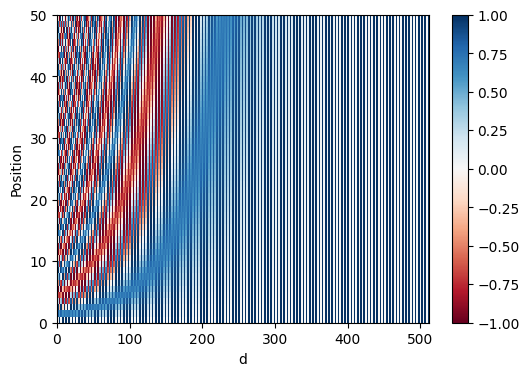

In [36]:
positions = 50
d = 512
pos_encoding = positional_encoding(positions, d)

print (pos_encoding.shape)

plt.figure(figsize = (6,4))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model.

In the case where the sequence is padded with zeros, we need to create a mask to let the algorithm know that it should discard the zero values.



In [37]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids -- (n, m) matrix. n=batch_size, m=fixed size of input sentences
    
    Returns:
        mask -- (n, 1, m) binary tensor
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding to the attention logits.
    return seq[:, tf.newaxis, :] 

In [38]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


In training, we have access to the complete correct output of the training example. The look-ahead mask helps the model pretend that it correctly predicted a part of the output and see if, without looking ahead, it can correctly predict the next output.

In [39]:
def create_look_ahead_mask(sequence_length):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        sequence_length -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

In [40]:
x = tf.random.uniform((1, 3))
create_look_ahead_mask(x.shape[1])

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

## Encoder

### Encoder Layer

In [41]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, H, d_model, dk, dv, dff, dropout_rate=0.1, layernorm_eps=1e-6):
        
        """
        Arguments:

        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        dropout_rate -- Dropout parameter used (during training) before all the residual connections
        layernorm_eps -- eta regularizing parameter for the Normalization layer 
        """
        
        super(EncoderLayer, self).__init__()
        
        self.mha = Multihead_Attention(H, d_model, dk, dv)
        self.ffn = FFNNLayer(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.dropout_mha = Dropout(dropout_rate)
        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, training=False, mask=None):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, Tq, d_model)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers. Defaults to False
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input. Defaults to None
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, Tq, d_model)
        """
        A = self.mha(x,x,x,mask=mask) # Self attention (batch_size, Tq, d_model)
        A = self.dropout_mha(A, training=training) #Apply Dropout during training
        
        
        #  Residual connection + Layer normalization
        out1 = self.layernorm1(x+A)  # (batch_size, Tq, d_model)

        # Pointwise ffn
        ffn_output = self.ffn(out1) # (batch_size, Tq, d_model)
        ffn_output = self.dropout_ffn(ffn_output, training=training) # Apply Dropout during training
        
        # Residual connection + Layer normalization
        encoder_layer_out = self.layernorm2(ffn_output+out1)  # (batch_size, input_seq_len, fully_connected_dim)
        
        return encoder_layer_out

In [44]:
## DEBUG
H = 8 
d_model = 512 
dk = 64 
v = 32 
dff = 2048 

layer = EncoderLayer(H, d_model, dk, dv, dff)

batch_size = 43 
Tq = 27

x = tf.random.uniform((batch_size, Tq, d_model))

output = layer(x,training=True)
print(output.shape)

(43, 27, 512)


### Full Encoder

In [45]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self, N, H, d_model, dk, dv, dff, dropout_rate=0.1, layernorm_eps=1e-6):
        """
        Arguments:
        
        N -- number of stackeds Encoder layers (=6 in the paper)
        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        dropout_rate -- Dropout parameter used (during training) before all the residual connections
        layernorm_eps -- eta regularizing parameter for the Normalization layer 
        """
        
        super(Encoder, self).__init__()
        
        self.layers=[EncoderLayer(H, d_model, dk, dv, dff, 
                                  dropout_rate=dropout_rate, 
                                  layernorm_eps=layernorm_eps)
                                  for i in range(N)]
    
    def call(self, x, training=False, mask=None):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, Tq, d_model)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers. Defaults to False
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input. Defaults to None
        Returns:
            encoder_out -- Tensor of shape (batch_size, Tq, d_model)
        """
                                  
        for layer in self.layers:
            x = layer(x, training=training, mask=mask)
                                  
        return x

In [47]:
## DEBUG

N = 6
H = 8 
d_model = 512 
dk = 64 
v = 32 
dff = 2048 

encoder = Encoder(N, H, d_model, dk, dv, dff)

batch_size = 43 
Tq = 27

x = tf.random.uniform((batch_size, Tq, d_model))

output = encoder(x,training=True)
print(output.shape)

(43, 27, 512)


## Decoder

### Decoder Layer

In [48]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self, H, d_model, dk, dv, dff, dropout_rate=0.1, layernorm_eps=1e-6):
        
        """
        Arguments:

        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        dropout_rate -- Dropout parameter used (during training) before all the residual connections
        layernorm_eps -- eta regularizing parameter for the Normalization layer 
        """
        
        super(DecoderLayer, self).__init__()
        
        self.mha1 = Multihead_Attention(H, d_model, dk, dv)
        self.mha2 = Multihead_Attention(H, d_model, dk, dv)
        self.ffn = FFNNLayer(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)
        self.dropout_mha1 = Dropout(dropout_rate)
        self.dropout_mha2 = Dropout(dropout_rate)                                     
        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, encoder_output, training=False, look_ahead_mask=None, padding_mask=None):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, Tv, d_model)
            encoder_output --  Tensor of shape (batch_size, Tv, d_model)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers. Defaults to False
            look_ahead_mask -- Boolean mask for the target_input. Defaults to None
            padding_mask -- Boolean mask for the second multihead attention layer. Defaults to None
        Returns:
            decoder_layer_out -- Tensor of shape (batch_size, Tq, d_model)
        """
        # 1st Masked MultiHead attention                                     
        A1 = self.mha1(x,x,x,mask=look_ahead_mask) # Self attention (batch_size, Tq, d_model)
        A1 = self.dropout_mha1(A1, training=training) #Apply Dropout during training
        
        #  Residual connection + Layer normalization
        out1 = self.layernorm1(x+A1)  # (batch_size, Tq, d_model)

        # 2nd Masked MultiHead attention                                     
        A2 = self.mha2(x,encoder_output,encoder_output,mask=padding_mask) # Self attention (batch_size, Tq, d_model)
        A2 = self.dropout_mha2(A2, training=training) #Apply Dropout during training
        
        
        #  Residual connection + Layer normalization
        out2 = self.layernorm2(out1+A2)  # (batch_size, Tq, d_model)
                                             
        # Pointwise ffn
        ffn_output = self.ffn(out2) # (batch_size, Tq, d_model)
        ffn_output = self.dropout_ffn(ffn_output, training=training) # Apply Dropout during training
        
        # Residual connection + Layer normalization
        decoder_layer_out = self.layernorm3(ffn_output+out2)  # (batch_size, input_seq_len, fully_connected_dim)
        
        return decoder_layer_out

In [51]:
## DEBUG

N = 6
H = 8 
d_model = 512 
dk = 64 
v = 32 
dff = 2048 

layer = DecoderLayer(H, d_model, dk, dv, dff)

batch_size = 43 
Tq = 57 
Tv = 57 

x = tf.random.uniform((batch_size, Tv, d_model))
encoder_output = tf.random.uniform((batch_size, Tq, d_model))

output = layer(x,encoder_output,training=True)
print(output.shape)

(43, 57, 512)


### Full Decoder

In [52]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, N, H, d_model, dk, dv, dff, dropout_rate=0.1, layernorm_eps=1e-6):
        
        """
        Arguments:

        N -- number of stackeds Decoder layers (=6 in the paper)
        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        dropout_rate -- Dropout parameter used (during training) before all the residual connections
        layernorm_eps -- eta regularizing parameter for the Normalization layer 
        """
        
        super(Decoder, self).__init__()
        
        self.layers=[DecoderLayer(H, d_model, dk, dv, dff, 
                                  dropout_rate=dropout_rate, 
                                  layernorm_eps=layernorm_eps)
                                  for i in range(N)]
    
    def call(self, x, encoder_output, training=False, look_ahead_mask=None, padding_mask=None):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, Tv, d_model)
            encoder_output --  Tensor of shape (batch_size, Tv, d_model)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers. Defaults to False
            look_ahead_mask -- Boolean mask for the target_input. Defaults to None
            padding_mask -- Boolean mask for the second multihead attention layer. Defaults to None
        Returns:
            decoder_out -- Tensor of shape (batch_size, Tq, d_model)
        """
        
        for layer in self.layers:
            x = layer(x,encoder_output, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
                                  
        return x

In [53]:
## DEBUG

N = 6
H = 8 
d_model = 512 
dk = 64 
v = 32 
dff = 2048 

decoder = Decoder(N,H, d_model, dk, dv, dff)

batch_size, Tq, Tv= 43, 57, 57
x = tf.random.uniform((batch_size, Tv, d_model))
encoder_output = tf.random.uniform((batch_size, Tq, d_model))

output = decoder(x,encoder_output,training=True)
print(output.shape)

(43, 57, 512)


## Transformer

In [54]:
class Transformer(tf.keras.Model):
    
    def __init__(self, N, H, d_model, dk, dv, dff, 
                 vocab_size, max_positional_encoding, 
                 dropout_rate=0.1, layernorm_eps=1e-6):

        super(Transformer, self).__init__()
        
        initializer = tf.keras.initializers.GlorotUniform()
        self.embedding = tf.Variable(initializer(shape=(vocab_size, d_model)), trainable=True)
        self.PE = positional_encoding(max_positional_encoding, d_model)
        
        self.dropout_encoding_input = Dropout(dropout_rate)
        self.dropout_decoding_input = Dropout(dropout_rate)
        
        self.encoder = Encoder(N, H, d_model, dk, dv, dff, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)
        self.decoder = Decoder(N, H, d_model, dk, dv, dff, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)

        

    def call(self, x, y, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        
        x = tf.matmul(x,self.embedding)
        x = x + self.PE
        x =  self.dropout_encoding_input(x,training=training)
        
        encoder_output = self.encoder(x,training=training, mask=enc_padding_mask)
        
        y = tf.matmul(y,self.embedding)
        y = y + self.PE
        y = self.dropout_decoding_input(y,training=training)
        
        dec_output = self.decoder(y, encoder_output, training=training, 
                                  look_aheasd_mask=look_ahead_mask, padding_mask=dec_padding_mask)
        
        
        pred =  tf.matmul(self.embedding,dec_output,transpose_b=True)
        pred = tf.nn.softmax(pred)
        
        return pred

In [55]:
N = 6
H = 8 
d_model = 512 
dk = 64 
v = 32 
dff = 2048 

vocab_size =29
T = 11
batch_size = 3


transformer = Transformer(N, H, d_model, dk, dv, dff, 
                 vocab_size, T)

input_shape = (None, T,vocab_size)


x = tf.random.uniform((batch_size, T, vocab_size))
y = tf.random.uniform((batch_size, T, vocab_size))

pred = transformer(x,y,training=True)
print(pred.shape)

transformer.summary()

(3, 29, 11)
Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_57 (Dropout)        multiple                  0         
                                                                 
 dropout_58 (Dropout)        multiple                  0         
                                                                 
 encoder_2 (Encoder)         multiple                  17329152  
                                                                 
 decoder_1 (Decoder)         multiple                  22053888  
                                                                 
Total params: 39,397,888
Trainable params: 39,397,888
Non-trainable params: 0
_________________________________________________________________


### Learning Rate Scheduler

In [56]:
#We implement a callback that should be called during training to update the learning rate

warmup_step = 4000
class LearningRateScheduler(tf.keras.callbacks.Callback):
    def on_train_batch_start(self, i, batch_logs):
        transformer.optimizer.lr = dk**(-0.5)*min(i**(-0.5),warmup_step**(-3/2)*i)


callback = LearningRateScheduler()

### Compile

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0, beta_1=0.9, beta_2=0.98, epsilon=1e-09)

transformer.compile(loss='crossentropy',optimizer=optimizer,metrics=['accuracy'])